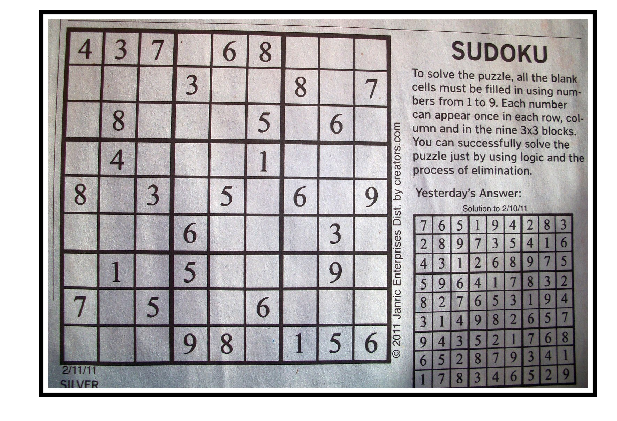

In [103]:
from skimage.io import imread
import matplotlib.pyplot as plt
import math
import os
from skimage.io import imread
from skimage.color import rgb2grey
from skimage.measure import approximate_polygon
from skimage.filters import gaussian
from skimage.color import rgb2grey
from skimage.filters import threshold_adaptive, threshold_yen, threshold_local
from scipy import ndimage as ndi
from skimage.measure import find_contours
from skimage.draw import polygon_perimeter
import numpy as np
from skimage import transform as tf
import skimage
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.ndimage import gaussian_filter

sudoku_original = imread('http://1.bp.blogspot.com/-7y7o4rdh_G8/TVWnhbfmPrI/AAAAAAAAAHA/ZW_s56iEZMo/s1600/sudoku%2B001.jpg')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sudoku_original)
plt.show()

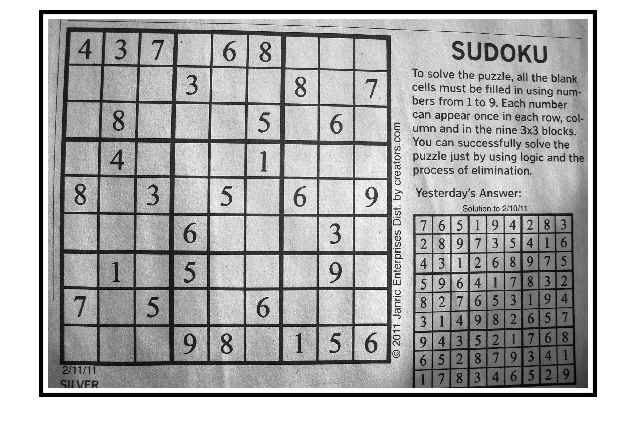

In [106]:
blurred = rgb2grey(sudoku_original)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(blurred, cmap="gray")
plt.show()

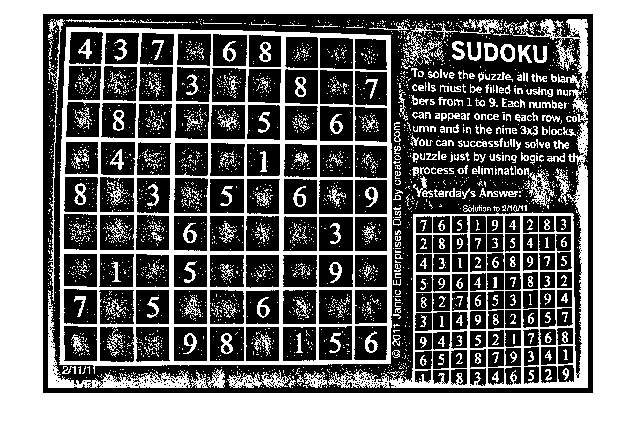

In [107]:
#adaptive threshold
#ref : http://scikit-image.org/docs/0.12.x/auto_examples/segmentation/plot_threshold_adaptive.html
binary_adaptive = threshold_local(blurred, block_size=99)
binary = blurred <= binary_adaptive
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(binary , cmap="gray")
plt.show()

In [109]:
bimg = binary
# bimg = ndi.binary_fill_holes(binary)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(bimg , cmap="gray")
# plt.show()

In [110]:
#all utilities
def clear_noisy_borders(six):
    #vertical first
    for i in range(20):
        if((six[:,i] == 0).sum() > 80):
            six[:,i] = (six[:,i]*0)+1

    for i in range(110,128):
        if((six[:,i] == 0).sum() > 80):
            six[:,i] = (six[:,i]*0)+1

    #horizontal now
    for i in range(20):
        if((six[i,:] == 0).sum() > 80):
            six[i,:] = (six[i,:]*0)+1

    for i in range(110,128):
        if((six[i,:] == 0).sum() > 80):
            six[i,:] = (six[i,:]*0)+1
    
    return six

def area_of_rectangle(Xmin, Xmax, Ymin, Ymax):
    return ((Ymax-Ymin)*(Xmax-Xmin))

def find_areas_bound_by_contours(contours):
    areas_bound_by_contours = []
    for index, contour in enumerate(contours):
        Xmin = np.min(contour[:,0])
        Xmax = np.max(contour[:,0])
        Ymin = np.min(contour[:,1])
        Ymax = np.max(contour[:,1])
        areas_bound_by_contours.append([index,area_of_rectangle(Xmin, Xmax, Ymin, Ymax)])
        
    return areas_bound_by_contours

def get_highest_area(areas_bound_by_contours):
    highest_area = [0,0]
    for areas in areas_bound_by_contours:
        if areas[1] > highest_area[1]:
            highest_area = areas
    return highest_area

def fill_holes(six):
    return ndi.binary_fill_holes(six)

#ref:https://stackoverflow.com/questions/1211212/how-to-calculate-an-angle-from-three-points
def findAngle(p0,p1,p2):
    b = (p1[0]-p0[0])**2 + (p1[1]-p0[1])**2
    a = (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2
    c = (p2[0]-p0[0])**2 + (p2[1]-p0[1])**2
    return math.degrees(math.acos( (a+b-c) / math.sqrt(4*a*b) ))


def pre_process_block(box):
    #box = warped[row*100:row*100+100,col*100:col*100+100].copy()
    box = skimage.transform.resize(box,(128,128))
    box = gaussian_filter(box, 1)
    box_binary_adaptive = threshold_local(box, block_size=99)
    binary = box <= box_binary_adaptive
    box = skimage.util.invert(binary)*1
    box = clear_noisy_borders(box)
    contours = find_contours(box, level=0.8)
    areas_bound_by_contours = find_areas_bound_by_contours(contours)

    for area in areas_bound_by_contours:
        threshold = 0.33
        percentage_of_area = area[1]/(128*128)
        if percentage_of_area<threshold:
            cont = contours[area[0]].astype(int)
            Xmin = np.min(cont[:,0])
            Xmax = np.max(cont[:,0])
            Ymin = np.min(cont[:,1])
            Ymax = np.max(cont[:,1])
            box[Xmin:Xmax, Ymin:Ymax] = 1

    return box

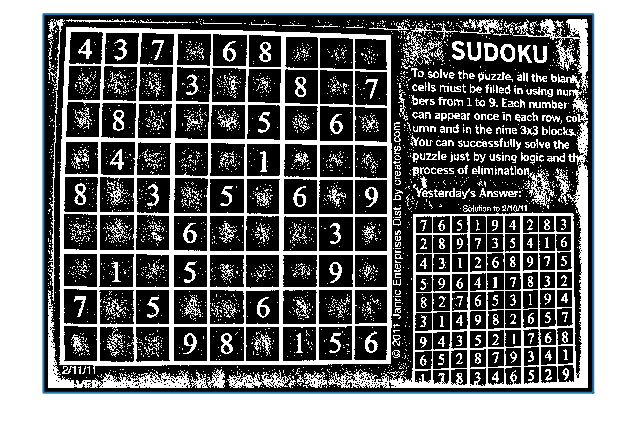

In [111]:
contours = find_contours(bimg, 0.8)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(bimg, interpolation='nearest', cmap=plt.cm.gray)

#find the largest blob
lengths = []
for c in contours:
    lengths.append(len(c))

areas_bound_by_contours = find_areas_bound_by_contours(contours)
highest_area = get_highest_area(areas_bound_by_contours)

ax.axis("off")
ax.plot(contours[highest_area[0]][:, 1], contours[highest_area[0]][:, 0], linewidth=2)  
plt.show()

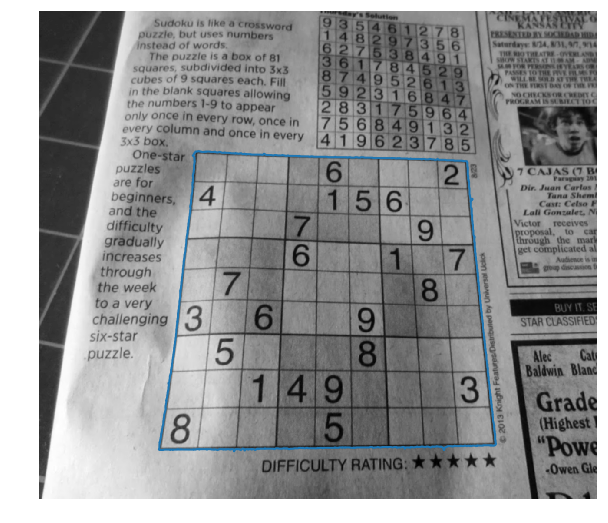

In [7]:
cimp = contours[highest_area[0]]

fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(blurred, cmap="gray")
ax.plot(contours[highest_area[0]][:, 1], contours[highest_area[0]][:, 0], linewidth=2)

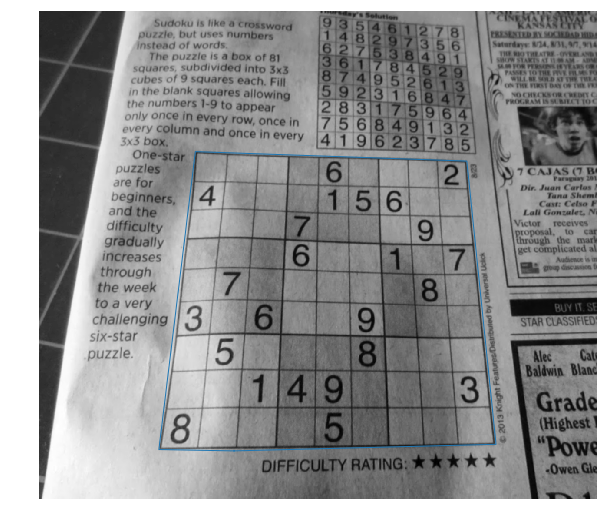

In [8]:
polygon = approximate_polygon(cimp,50)

fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(blurred, cmap="gray")
ax.plot(polygon[:, 1], polygon[:, 0], linewidth=1) 

In [9]:
angles_and_points = []
npoints = len(polygon)-1
for i in range(npoints):
    p1index = i
    p2index = i + 1
    p3index = i + 2
    
    if p1index == npoints-2:
        p3index = 0
        
    if p1index == npoints-1:
        p2index = 0
        p3index = 1
    
    try:
        angle = findAngle(polygon[p1index],polygon[p2index],polygon[p3index])
        if angle < 110:
            angles_and_points.append([polygon[p2index],angle])
    except:
        pass

In [10]:
x = []
y = []
for k in angles_and_points:
    x.append(k[0][1])
    y.append(k[0][0])

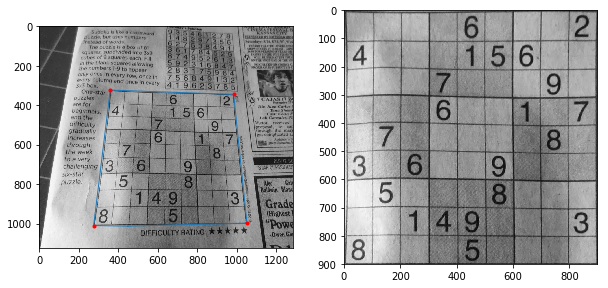

In [11]:
src = np.array([[0, 0], [0, 900], [900, 900], [900, 0]])
dst = np.array([[x[1],y[1]], [x[0],y[0]], [x[3],y[3]], [x[2],y[2]] ])

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = tf.warp(gray_img, tform3, output_shape=(900, 900))

fig, ax = plt.subplots(ncols=2,figsize=(10,20))
ax[0].imshow(gray_img, cmap="gray")
ax[0].plot(polygon[:, 1], polygon[:, 0], linewidth=1)
ax[0].plot(x, y, '.r')

ax[1].imshow(warped, cmap="gray")

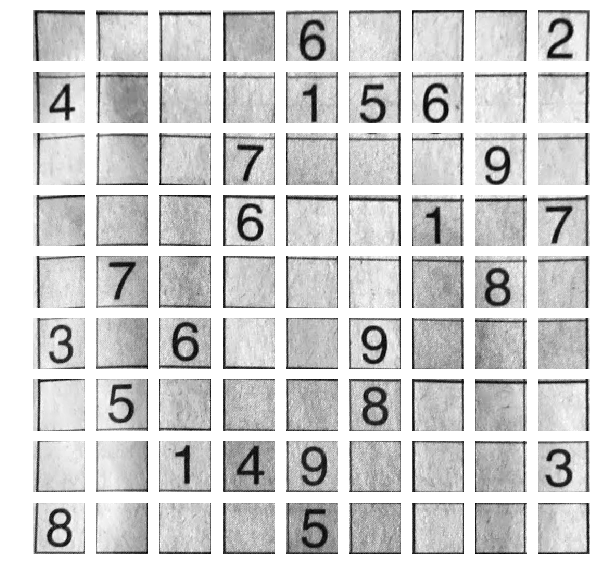

In [12]:
#divide the transformed image into 9 x 9 grid.
fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(10,10))
for row in range(9):
    for col in range(9):
        ax[row][col].axis("off")
        ax[row][col].imshow(warped[row*100:row*100+100,col*100:col*100+100] , cmap="gray") 

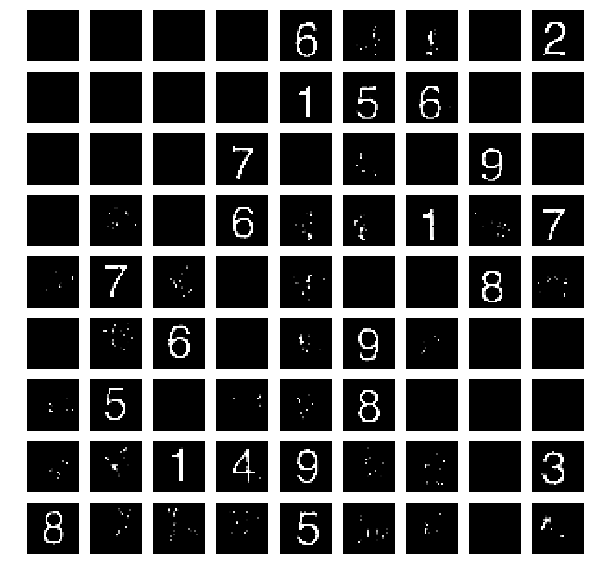

In [80]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.morphology import binary_erosion, binary_dilation
from keras.models import load_model

model = load_model('mldata\keras_digits.h5')
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 1)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    return vector

def predict(box):
    threshold = 4
    contours = find_contours(box, level=0.8)
    total_contour_area = np.sum(find_areas_bound_by_contours(contours))
    if len(contours) > threshold or len(contours) == 0 or total_contour_area < 40:
        return 0
    else:
        return model.predict_classes(box.reshape(1,28,28,1).astype(np.uint8))[0]

fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(10,10))

predicted_vals = np.zeros((9,9))
contours_found = np.zeros((9,9))
boxes = []
for row in range(9):
    for col in range(9):
        box = warped[row*100:row*100+100,col*100:col*100+100]
        box = skimage.transform.resize(box,(128,128))
        box_binary_adaptive = threshold_local(box, block_size=99)
        binary = box <= box_binary_adaptive
        box = skimage.util.invert(binary)*1
        
        #find what this number is.
        box = clear_noisy_borders(box)
        box = np.pad(box, 10, pad_with)
        box = binary_dilation(binary_dilation(binary_dilation(box)))
        box = skimage.util.invert(box)
        box = skimage.transform.resize(box,(28,28))
        contours = find_contours(box, level=0.8) 
        
        if(len(contours) >= 5):
            box = (box*0)+1

        boxes.append(box)
        contours = find_contours(box, level=0.8) 
        
        ax[row][col].axis("off")
        ax[row][col].imshow(box , cmap="gray")
        
        contours_found[row][col] = len(contours)
        predicted_vals[row][col] = predict(box)
        
plt.show()

In [81]:
true_vals = np.array([[0., 0., 0., 0., 6., 0., 0., 0., 2.],
       [4., 0., 0., 0., 1., 5., 6., 0., 0.],
       [0., 0., 0., 7., 0., 0., 0., 9., 0.],
       [0., 0., 0., 6., 0., 0., 1., 0., 7.],
       [0., 7., 0., 0., 0., 0., 0., 8., 0.],
       [3., 0., 6., 0., 0., 9., 0., 0., 0.],
       [0., 5., 0., 0., 0., 8., 0., 0., 0.],
       [0., 0., 1., 4., 9., 0., 0., 0., 3.],
       [8., 0., 0., 0., 5., 0., 0., 0., 0.]])

print 'acuracy:', np.sum(true_vals == predicted_vals)*100.0/81
print 'wrong found:', 81 - np.sum(true_vals == predicted_vals)

acuracy: 92.5925925925926
wrong found: 6


In [82]:
predicted_vals

array([[0., 0., 0., 0., 5., 0., 0., 0., 2.],
       [0., 0., 0., 0., 1., 5., 8., 0., 0.],
       [0., 0., 0., 7., 0., 0., 0., 9., 0.],
       [0., 0., 0., 5., 0., 0., 1., 0., 7.],
       [0., 7., 0., 0., 0., 0., 0., 8., 0.],
       [0., 0., 5., 0., 0., 9., 0., 0., 0.],
       [0., 5., 0., 0., 0., 8., 0., 0., 0.],
       [0., 0., 1., 4., 9., 0., 0., 0., 3.],
       [8., 0., 0., 0., 5., 0., 0., 0., 0.]])

In [83]:
contours_found

array([[0., 0., 0., 0., 3., 4., 2., 0., 2.],
       [0., 0., 0., 0., 1., 3., 4., 0., 0.],
       [0., 0., 0., 2., 0., 4., 0., 3., 0.],
       [0., 4., 0., 2., 4., 3., 1., 3., 2.],
       [2., 3., 4., 0., 4., 0., 0., 2., 3.],
       [0., 4., 2., 0., 2., 2., 1., 0., 0.],
       [3., 3., 0., 2., 4., 3., 0., 0., 0.],
       [2., 4., 1., 4., 3., 3., 4., 0., 2.],
       [2., 4., 3., 3., 2., 3., 2., 0., 4.]])

In [112]:
ebox = sudoku_original
contours = find_contours(ebox, level=0.8)
print np.sum(find_areas_bound_by_contours(contours))
fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(ebox, cmap="gray")
for i in range(len(contours)-1):
    ax.plot(contours[i][:, 1], contours[i][:, 0], linewidth=2)

ValueError: Only 2D arrays are supported.